# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

mat = loadmat('MR_data.mat')

In [2]:
def show_img(img, title='', cmap='gray'):
    plt.figure(figsize=(img.shape[0] / 100, img.shape[1] / 100), dpi=200)
    plt.imshow(img, cmap=cmap)
    plt.xticks([]), plt.yticks([])
    plt.title(title)
    plt.show()

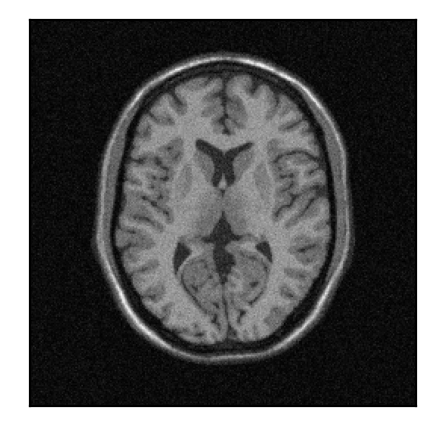

In [3]:
show_img(mat['I_noisy1'])

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [4]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum() 
    
    
def mesh(fun, size):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    
    ax.plot_surface(X, Y, Z)
    
    plt.show()

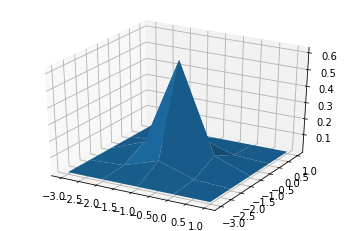

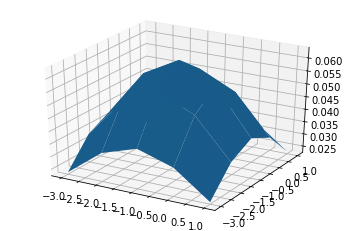

In [5]:
mesh(fgaussian(5, 0.5), 5)
mesh(fgaussian(5, 2), 5)

In [6]:
def classic(image, window_size=5, sigma_S=1.5):
    w, h = image.shape
    kernel = fgaussian(window_size, sigma_S)
    new_img = np.zeros((w, h))
    offset = window_size // 2

    for i in range(offset, w - offset):
        for j in range(offset, h - offset):
            window = image[i - offset : i + offset + 1, j - offset : j + offset + 1]
            new_img[i, j] = np.sum(window * kernel)
    
    return new_img

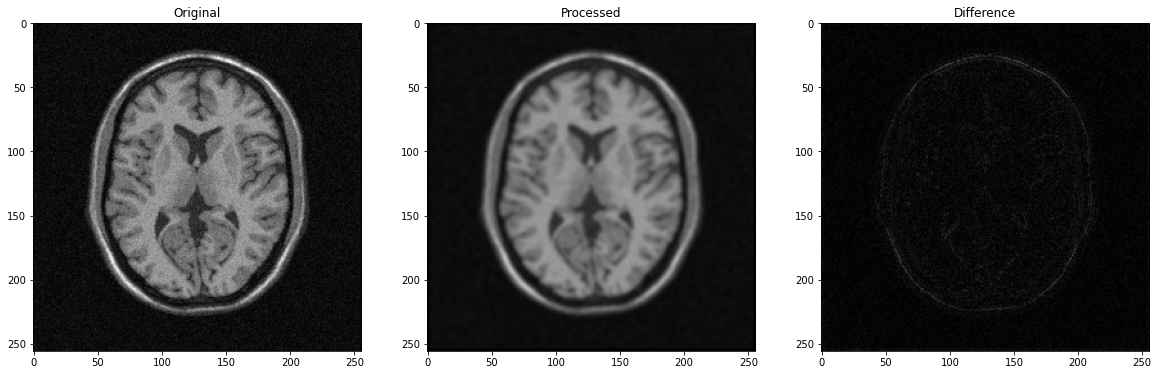

In [7]:
mat_f = classic(mat['I_noisy1'])
mat_diff = np.abs(mat_f.astype('int32') - mat['I_noisy1'].astype('int32'))

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(mat['I_noisy1'], 'gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[1].imshow(mat_f, 'gray', vmin=0, vmax=255)
axs[1].set_title('Processed')
axs[2].imshow(mat_diff, 'gray', vmin=0, vmax=255)
axs[2].set_title('Difference')
plt.show()

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [8]:
def bilateral(image, window_size=5, sigma_S=1.5, sigma_R=16):
    w, h = image.shape
    kernel_g = fgaussian(window_size, sigma_S)
    new_img = np.zeros((w, h))
    offset = window_size // 2

    def get_kernel(window):
        kernel_b = np.zeros((window_size, window_size))
        center_value = window[offset, offset]

        for x in range(window_size):
            for y in range(window_size):
                kernel_b[x, y] = np.exp(-(window[x, y] - center_value)**2 / (2 * sigma_R**2))

        kernel = kernel_g * kernel_b
        kernel /= np.sum(kernel)

        return kernel

    
    for i in range(offset, w - offset):
        for j in range(offset, h - offset):
            window = image[i - offset : i + offset + 1, j - offset : j + offset + 1]
            kernel = get_kernel(window)
            new_img[i, j] = np.sum(window * kernel)
    
    return new_img

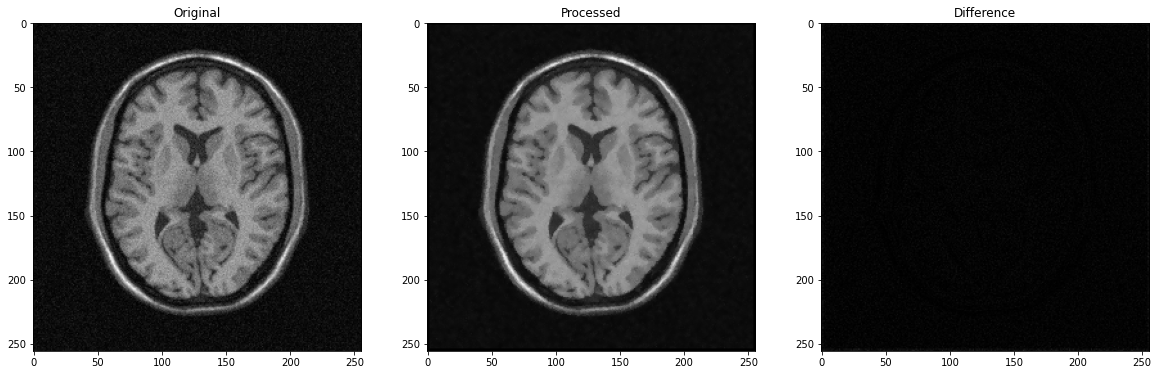

In [9]:
mat_b = bilateral(mat['I_noisy1'])
mat_b_diff = np.abs(mat_b.astype('int32') - mat['I_noisy1'].astype('int32'))

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(mat['I_noisy1'], 'gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[1].imshow(mat_b, 'gray', vmin=0, vmax=255)
axs[1].set_title('Processed')
axs[2].imshow(mat_b_diff, 'gray', vmin=0, vmax=255)
axs[2].set_title('Difference')
plt.show()

<ipython-input-8-b9ae454f4e66>:13: RuntimeWarning: overflow encountered in ubyte_scalars
  kernel_b[x, y] = np.exp(-(window[x, y] - center_value)**2 / (2 * sigma_R**2))


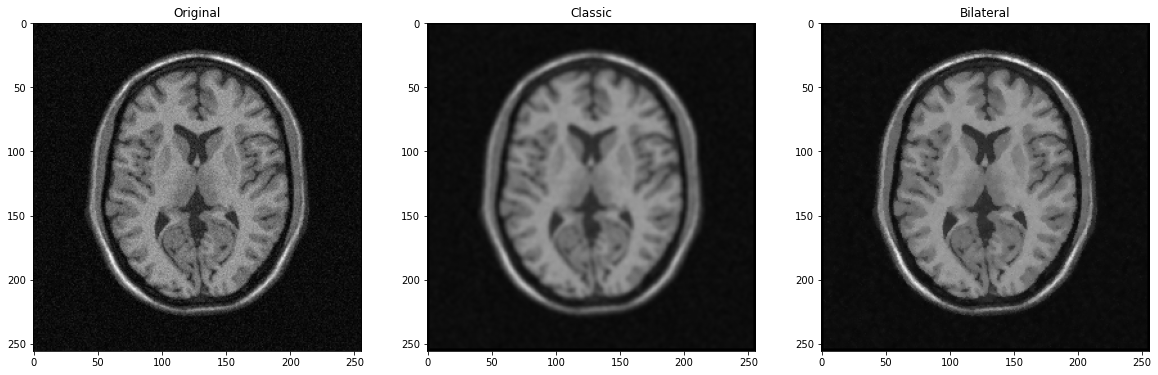

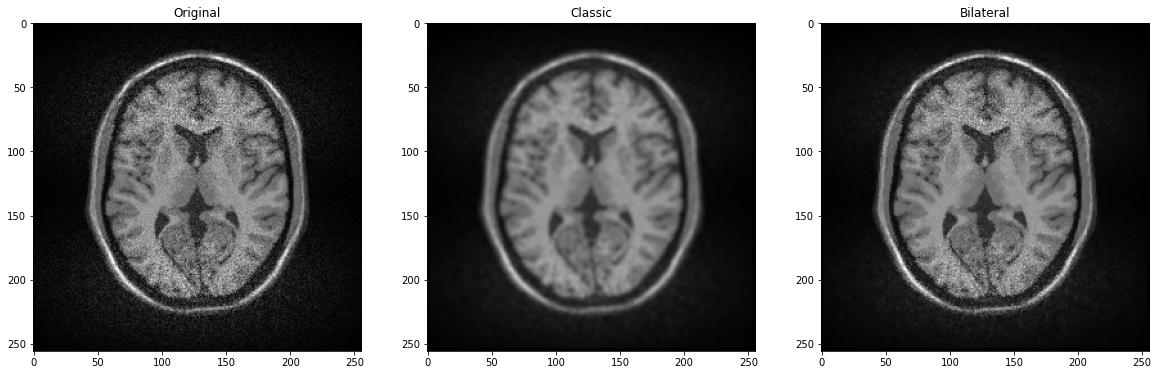

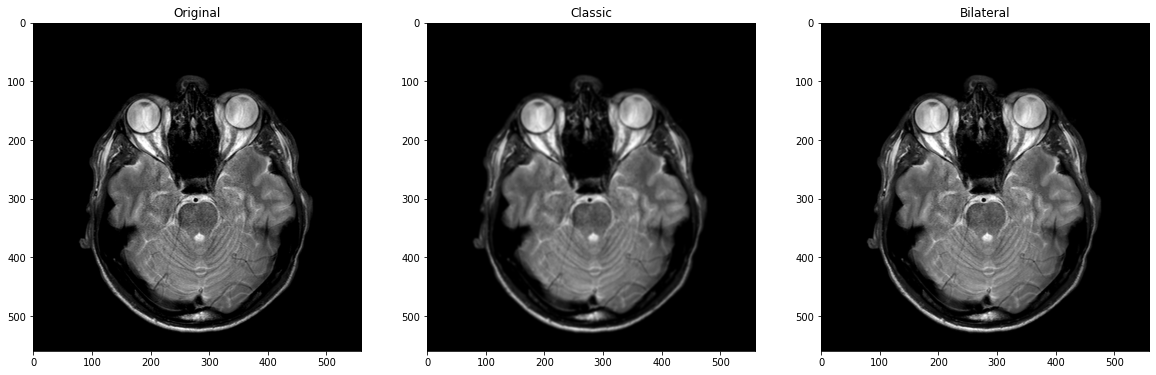

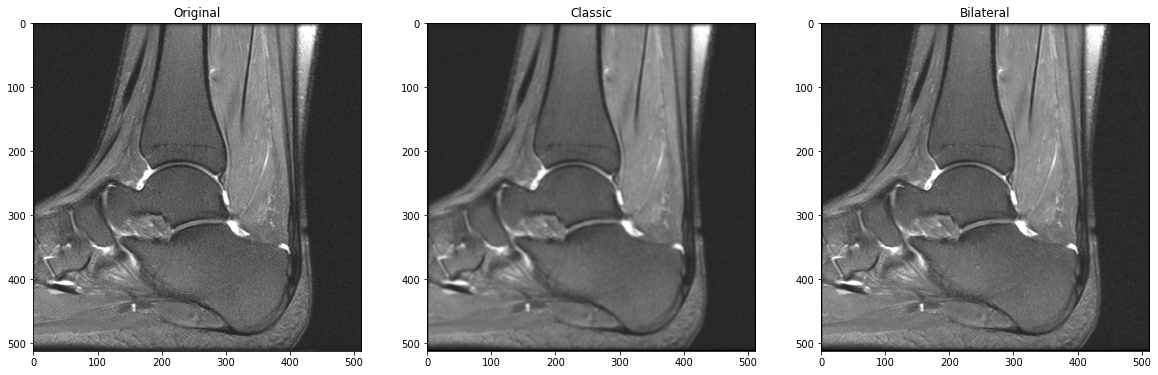

In [10]:
mat_1 = classic(mat['I_noisy1'])
mat_b_1 = bilateral(mat['I_noisy1'])
mat_2 = classic(mat['I_noisy2'])
mat_b_2 = bilateral(mat['I_noisy2'])
mat_3 = classic(mat['I_noisy3'])
mat_b_3 = bilateral(mat['I_noisy3'])
mat_4 = classic(mat['I_noisy4'])
mat_b_4 = bilateral(mat['I_noisy4'])

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(mat['I_noisy1'], 'gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[1].imshow(mat_1, 'gray', vmin=0, vmax=255)
axs[1].set_title('Classic')
axs[2].imshow(mat_b_1, 'gray', vmin=0, vmax=255)
axs[2].set_title('Bilateral')
plt.show()
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(mat['I_noisy2'], 'gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[1].imshow(mat_2, 'gray', vmin=0, vmax=255)
axs[1].set_title('Classic')
axs[2].imshow(mat_b_2, 'gray', vmin=0, vmax=255)
axs[2].set_title('Bilateral')
plt.show()
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(mat['I_noisy3'], 'gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[1].imshow(mat_3, 'gray', vmin=0, vmax=255)
axs[1].set_title('Classic')
axs[2].imshow(mat_b_3, 'gray', vmin=0, vmax=255)
axs[2].set_title('Bilateral')
plt.show()
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(mat['I_noisy4'], 'gray', vmin=0, vmax=255)
axs[0].set_title('Original')
axs[1].imshow(mat_4, 'gray', vmin=0, vmax=255)
axs[1].set_title('Classic')
axs[2].imshow(mat_b_4, 'gray', vmin=0, vmax=255)
axs[2].set_title('Bilateral')
plt.show()